## 모듈 선언

In [1]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json
from soynlp.normalizer import *
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np

`from soynlp.normalizer import *`  
한국어 분석을 위한 pure python code
- 학습데이터를 이용하지 않으면서 데이터에 존재하는 단어를 찾거나, 문장을 단어열로 분해, 혹은 품사 판별을 할 수 있는 비지도학습 접근법을 지향합니다.
- [Github Link](https://github.com/lovit/soynlp)

---



## 파일 읽기

### 1) Train Data

#### CSV file read (as DataFrame)

In [2]:
train_data_path ="/aiffel/aiffel/train_ai_last.csv"
train_data = pd.read_csv(train_data_path)

### 2) Validation Data

#### CSV file read (as DataFrame)

In [3]:
val_data_path = "/aiffel/aiffel/val.csv"
val_data = pd.read_csv(val_data_path)

#### Data Read (with `tail`)

##### Train Data

In [4]:
train_data.tail()

,Unnamed: 0,idx,class,conversation
3945,3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n밥먹으면 대가리만 크냐 너는?\n주위를 둘러봐...
3946,3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n말로?...
3947,3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n들리라고 해. 아니...
3948,3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n남의 구역에서 장사하려면 자릿세를 내야지.\n그거랑 ...
3949,3949,3949,직장 내 괴롭힘 대화,네?\n갑자기 왜그러세요?\n네 여름이라 기분전환으로.\n그냥 파스텔톤으로만 칠한건...


##### Validation Data

In [5]:
val_data.tail()

,class,conversation
785,직장 내 괴롭힘 대화,씨 요즘 얼굴 좋아보이네 아 감사합니다 씨는 성격이 참 좋은 것 같아 눈치가 없는건...
786,직장 내 괴롭힘 대화,길동씨 아파요 네 아뇨 얼굴이 죽은사람같네 죽은사람이라뇨 립스틱이라도 발라 화장했는...
787,갈취 대화,저기 학생 돈 좀 얼마 줄 수 있나 아 할머니 얼마나 필요하세요 만원정도 필요해 죄...
788,직장 내 괴롭힘 대화,어이 너희들 용모가 왜이리 단정하지 못하냐 중대장님 왜그러 십니까 전역이 코앞입니다...
789,직장 내 괴롭힘 대화,너 이거 왜이리 못해 몇번을 말해야 알아먹어 죄송해요 맨날 죄송하다는 말만하니 죄송...


---

## 데이터 변환

### 1-1. Train data를 `sentences`에 저장

In [6]:
# 학습할 문장이 담길 배열
sentences = []

for val in tqdm(train_data['conversation'], desc="Generate sentences.."):
    # 전처리가 된 conversation을 val로 받아오기
    sentences.append(val)

Generate sentences..: 100%|██████████| 3950/3950 [00:00<00:00, 2078472.06it/s]


In [7]:
len(sentences)

3950

### 1-2. Validation data를 `sentences2`에 저장

In [8]:
# 학습할 문장이 담길 배열
sentences2 = []

for val in tqdm(val_data['conversation'], desc="Generate sentences.."):
    # 전처리가 된 conversation을 val로 받아오기
    sentences2.append(val)

Generate sentences..: 100%|██████████| 790/790 [00:00<00:00, 1605377.98it/s]


In [9]:
len(sentences2)

790

---

#### `class` 값은 숫자로 변환하여 저장한다
- `협박 관련 대화` &rarr; `0`
- `갈취 관련 대화` &rarr; `1`
- `직장 관련 대화` &rarr; `2`  
- `기타 관련 대화` &rarr; `3`

### 2-1. Train data의 클래스를  `lables`에 저장

In [10]:
labels = []

for val in tqdm(train_data['class'], desc="class label convert to num..."):    
    if '갈취' in val:
        labels.append(1)
    if '기타' in val:
        labels.append(3)
    if '직장' in val:
        labels.append(2)
    if '협박' in val:
        labels.append(0)

class label convert to num...: 100%|██████████| 3950/3950 [00:00<00:00, 1340087.42it/s]


In [11]:
len(labels)

3950

### 2-2. Validation data의 클래스를 `labels2`에 저장

In [12]:
labels2 = []

for val in tqdm(val_data['class'], desc="class label convert to num..."):    
    if '갈취' in val:
        labels2.append(1)
    if '기타' in val:
        labels2.append(3)
    if '직장' in val:
        labels2.append(2)
    if '협박' in val:
        labels2.append(0)

class label convert to num...: 100%|██████████| 790/790 [00:00<00:00, 1041326.26it/s]


In [13]:
len(labels2)

790

---

## 모델 학습 준비

### 1) 모델 학습용 파라미터 선언

In [14]:
# 토큰 최대 길이
MAX_LEN = 128
# 데이터 묶음 크기
BATCH_SIZE = 16
# Learning Rate
lr = 1e-5
# 훈련 횟수
EPOCH = 6

### 2) 데이터셋 분할

In [15]:
# Train data
train_sentences = sentences

# Val data
val_sentences = sentences2

# Train Label
train_labels = labels

# Val Label
val_labels = labels2

### 3) 사용하지 않는 변수 초기화

In [16]:
# 메모리 관리
del sentences
del sentences2
del labels
del labels2

### 4) 모델 선언
1. 모델: `bert-base-multilingual-cased`
2. BERT 토크나이저 사용

In [17]:
# BERT 토크나이저와 모델 준비
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5) 데이터(`train`, `validation`)를 BERT 형식으로 변환
1. `예시` &rarr; `[CLS] 안녕하세요 [SEP]`
2. 문장 구분 토큰을 추가하여 Encoding

In [18]:
# 데이터셋을 BERT 입력 형식으로 변환
train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=MAX_LEN) # 뒤쪽에 패딩
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=MAX_LEN)

### 6) Tensor 데이터셋 생성

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(100).batch(BATCH_SIZE)

print("Train tensor dataset generated!")

Train tensor dataset generated!


In [20]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

print("Validation tensor dataset generated!")

Validation tensor dataset generated!


---

## 모델 훈련

### 1) 모델 컴파일

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

---

### 2) 모델 구조 시각화

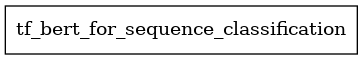

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True)

### 3) 모델 훈련

In [23]:
model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)

Epoch 1/6
247/247 [==============================] - 135s 486ms/step - loss: 0.9928 - accuracy: 0.5841 - val_loss: 0.5957 - val_accuracy: 0.7772
Epoch 2/6
247/247 [==============================] - 119s 480ms/step - loss: 0.5435 - accuracy: 0.8091 - val_loss: 0.4543 - val_accuracy: 0.8430
Epoch 3/6
247/247 [==============================] - 119s 480ms/step - loss: 0.3997 - accuracy: 0.8648 - val_loss: 0.4433 - val_accuracy: 0.8468
Epoch 4/6
247/247 [==============================] - 119s 480ms/step - loss: 0.3139 - accuracy: 0.8985 - val_loss: 0.3996 - val_accuracy: 0.8722
Epoch 5/6
247/247 [==============================] - 119s 480ms/step - loss: 0.2456 - accuracy: 0.9215 - val_loss: 0.3289 - val_accuracy: 0.8899
Epoch 6/6
247/247 [==============================] - 119s 480ms/step - loss: 0.1680 - accuracy: 0.9491 - val_loss: 0.3053 - val_accuracy: 0.9076


### 4) 모델 평가

In [24]:
evaluation = model.evaluate(val_dataset)

50/50 [==============================] - 7s 143ms/step - loss: 0.3053 - accuracy: 0.9076


---

## submission.csv 생성해보기

### 1) 파일 읽기 (`test.json`)

In [25]:
test_data_path ="/aiffel/aiffel/dktc/data/test.json"

with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)

### 2) 테스트 데이터 읽으면서 예측해보기

In [26]:
test_predicst = list()

for key in test:
    test_sentence = test[key]['text']
    
    test_encodings = tokenizer(test_sentence, truncation=True, padding=True, max_length=128, return_tensors="tf")
    
    test_predictions = model.predict({
        "input_ids": test_encodings["input_ids"],
        "token_type_ids": test_encodings["token_type_ids"],
        "attention_mask": test_encodings["attention_mask"]
    }) # [ 0.7805823,  2.6188664, -2.0281641, -0.9672525]
    test_class_probabilities = tf.nn.softmax(test_predictions.logits, axis=-1).numpy() # [[0.13297564 0.8358507  0.00801584 0.02315779]]
    test_predicted_class = np.argmax(test_class_probabilities, axis=1) # [ 1 ]
    test_predicst.append(test_predicted_class[0])

### 3) `submission.csv` 파일을 위한 `DataFrame` 생성

In [27]:
def labelnum_to_text(x):
    if x == 1 : # 갈취
        return '01'
    if x == 2 : # 직장
        return '02'
    if x == 3 : # 기타
        return '03'
    if x == 0 : # 협박 
        return '00'

submission = pd.DataFrame({'class':test_predicst}, index=list(test.keys()))
submission['class'] = submission['class'].apply(labelnum_to_text)
submission

,class
t_000,01
t_001,02
t_002,02
t_004,03
t_005,00
...,...
t_495,02
t_496,03
t_497,01
t_498,00


### 4) CSV 파일 저장

In [28]:
# 파일명 설정
file_name = "submission_test7_80_per_train_data_ai_preprocess.csv"

In [29]:
# 파일 생성
submission.to_csv(file_name)

# 테스트 회고

1. `OOM Error`로 인해 `MAX_LEN`를 크게 테스트 해보지 못했다. (ex: `300`)
    - 약간의 파라미터 수정은 수행하였다.
        - `learning rate`, `EPOCH`
2. 검증 데이터를 증강하지 않고 미리 분류하였다.
3. `from soynlp.normalizer import *`로 전처리된 CSV 파일을 가지고 수행하였다.
4. 데이터 EDA 관련해서 클래스에 유의미한 정보는 현재 설정한 `128` 값보다 뒤에 있는 경우가 많음을 알게 되었다.
    - 편향성 증가 우려가 있음
5. 훈련 데이터 전처리를 `chat gpt`를 통해 수행하였다.
    - 가해자 문장만 추출하기
    - 균일하지 않은 경우가 발생
    - 화자가 2인을 초과할 경우 정확하게 가해자, 피해자를 구분하기 어려운 이슈보임